In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
    
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_23568\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_23568\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

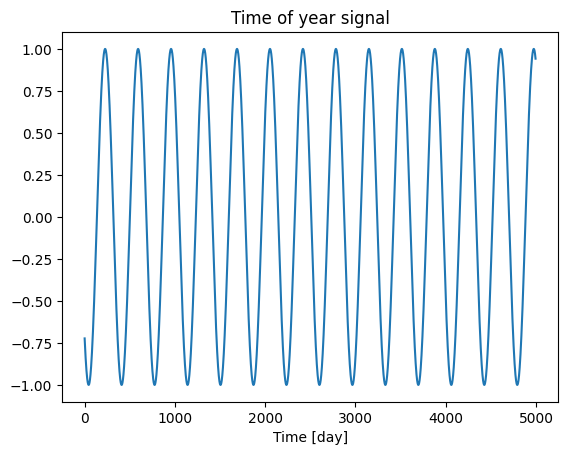

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

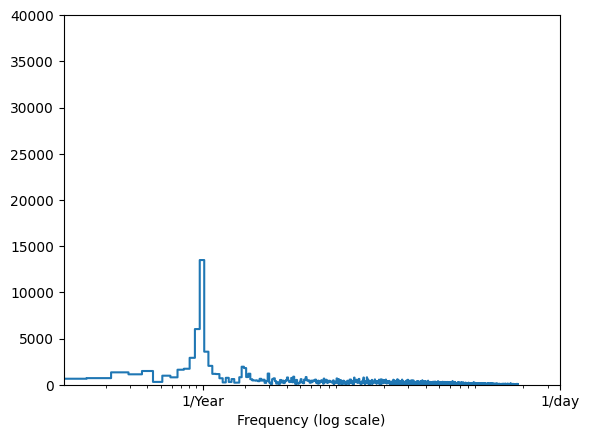

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [7]:
def create_data(in_steps, out_steps, data, features):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][features])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [8]:
in_steps = 90
out_steps = 14

In [9]:
X_train, y_train = create_data(in_steps, out_steps, train, ['temp','humidity'])
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 2)

X_test, y_test = create_data(in_steps, out_steps, test, ['temp','humidity'])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 2)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3892, 90, 10) (3892, 14, 2) (896, 90, 10) (896, 14, 2)


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(out_steps*2),
    tf.keras.layers.Reshape([out_steps, 2])
])



In [15]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [16]:
history = model.fit(X_train_norm, y_train_norm, epochs=30, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.2152 - val_loss: 0.0988
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0782 - val_loss: 0.0798
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0692 - val_loss: 0.0757
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0648 - val_loss: 0.0839
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0646 - val_loss: 0.0736
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0613 - val_loss: 0.0724
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0598 - val_loss: 0.0727
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0597 - val_loss: 0.0686
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0580 - val_loss: 0.0677
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0607 - val_loss: 0.0722
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0591 - val_loss: 0.0704
Epoch 12/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0

In [19]:
model.save('lstm90-not_overfit.keras') 

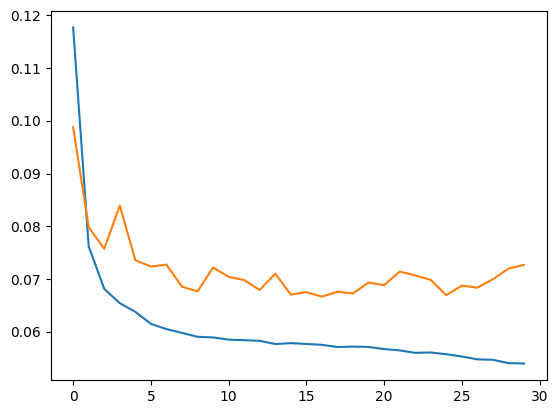

In [17]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])

In [18]:
model.evaluate(X_test_norm, y_test_norm)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0710


0.07361253350973129

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Day:  1
MAE:  1.3063525727816991
MSE:  3.1373932266149533
CORR:  0.9408615631562601
Day:  2
MAE:  1.8101572722196582
MSE:  5.5756414539719685
CORR:  0.8901554648026653
Day:  3
MAE:  2.123079178588731
MSE:  7.47335092515511
CORR:  0.8550410021012109
Day:  4
MAE:  2.293775498441288
MSE:  8.542901393294768
CORR:  0.8370457533151503
Day:  5
MAE:  2.2845533439091277
MSE:  8.400676440323812
CORR:  0.8311178047325306
Day:  6
MAE:  2.3107200388397495
MSE:  8.696785722916271
CORR:  0.8229812732365523
Day:  7
MAE:  2.405245225770133
MSE:  9.331347367230137
CORR:  0.8125404020284047
Day:  8
MAE:  2.5048197294984544
MSE:  9.815595422628835
CORR:  0.8082374200750734
Day:  9
MAE:  2.4207975502525056
MSE:  9.283261001367029
CORR:  0.8081346663038677
Day:  10
MAE:  2.427228834799358
MSE:  9.278578462465058
CORR:  0.8112507479113412
Day:  11
MAE:  2.4402039429971154
MSE:  9.474745558921859
CORR:  0.8082171735534192
Day:  12
MAE:  2.4254526598112927
MSE:  9.317437

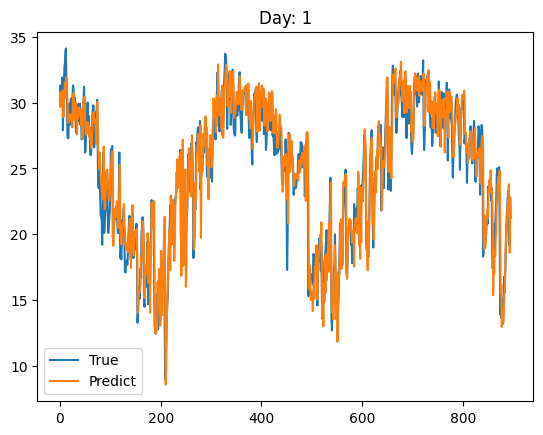

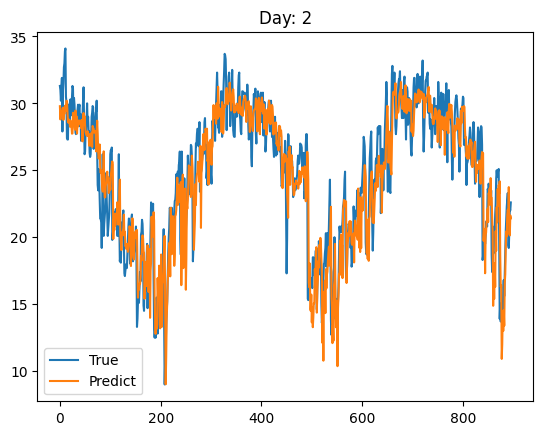

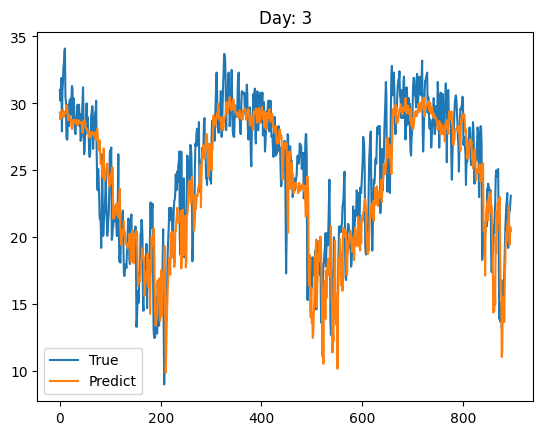

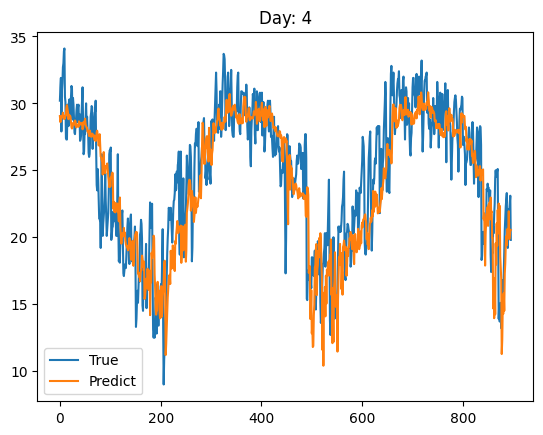

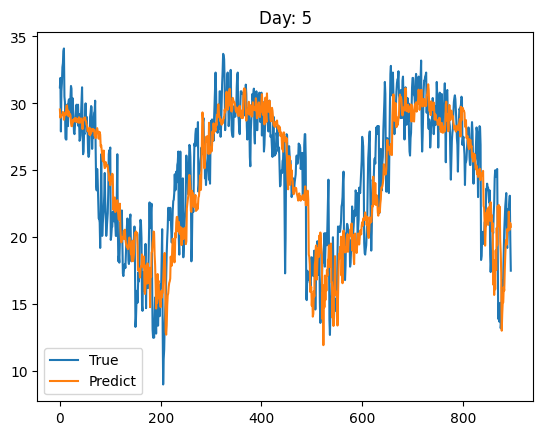

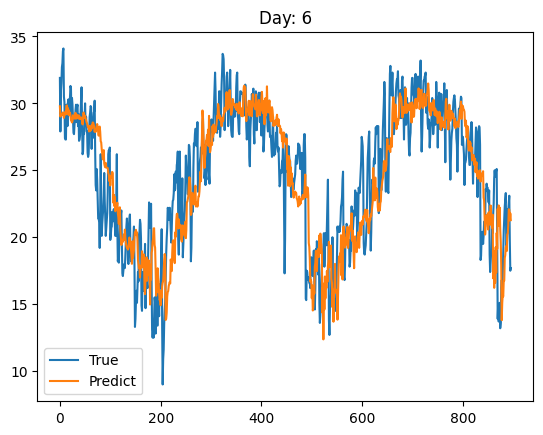

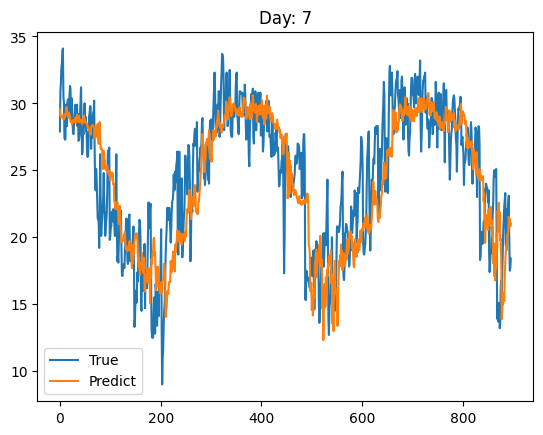

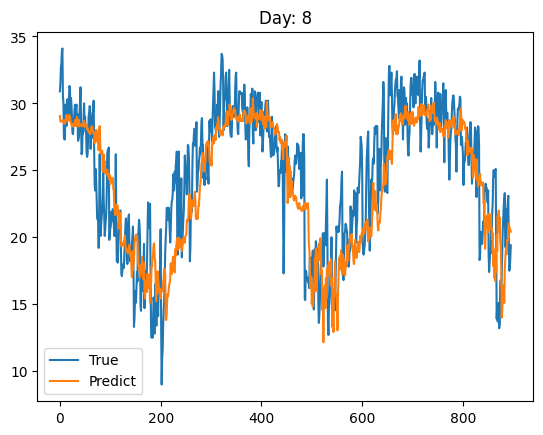

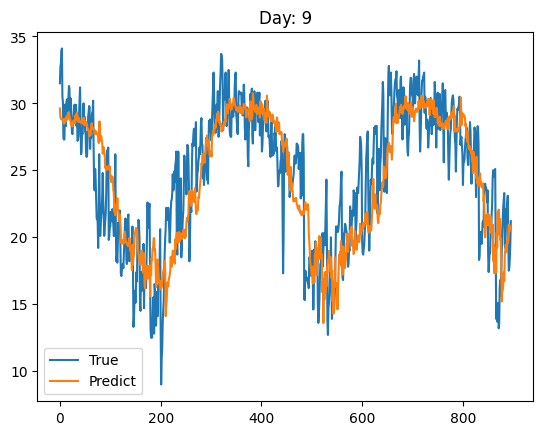

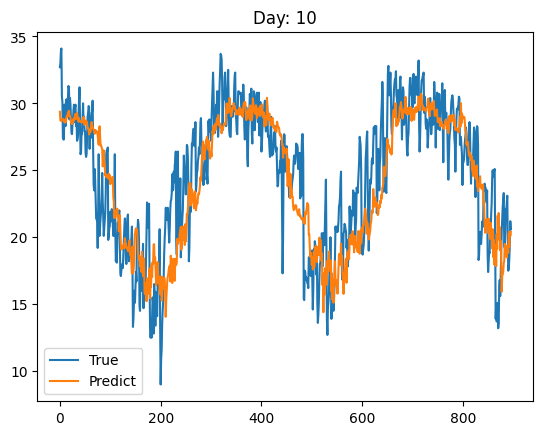

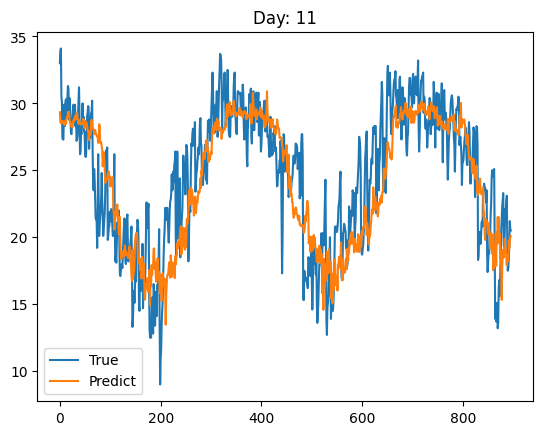

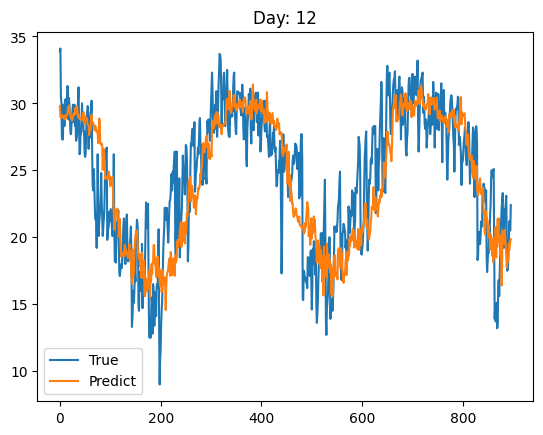

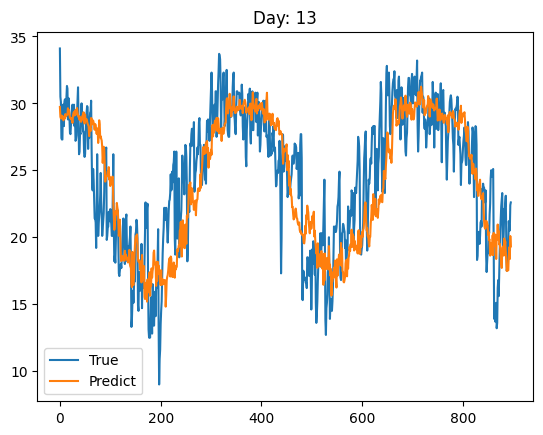

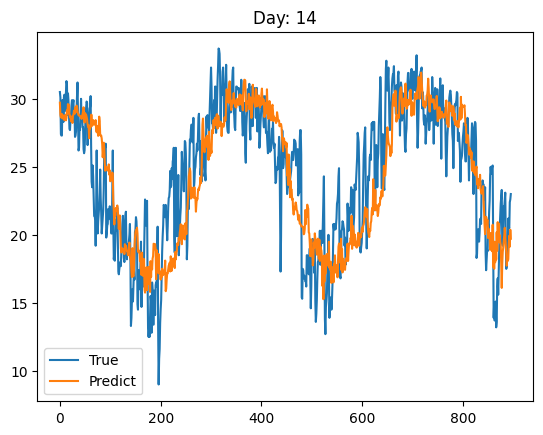

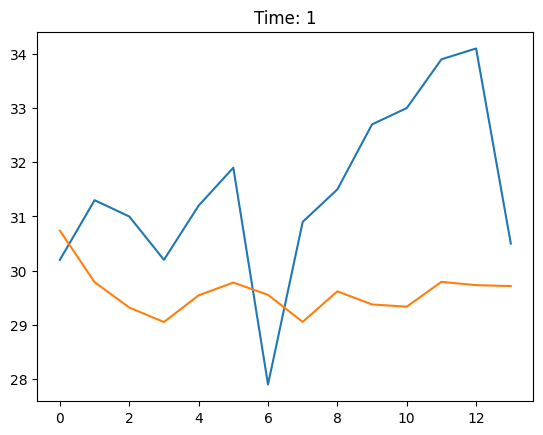

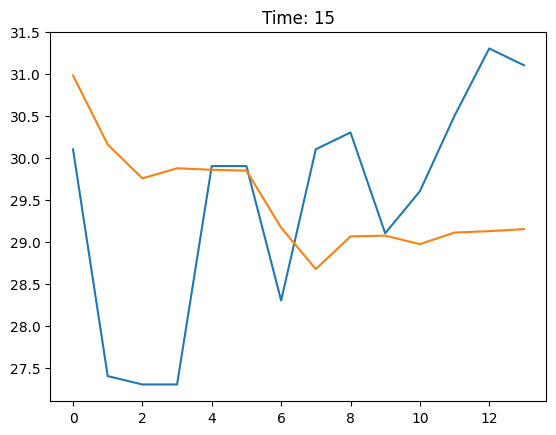

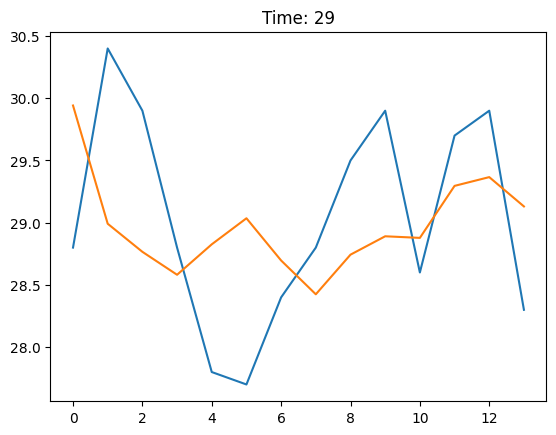

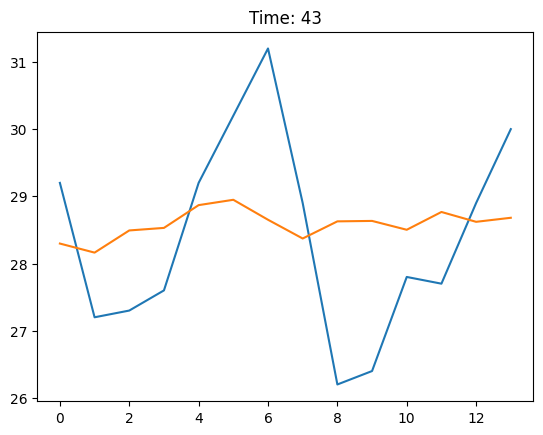

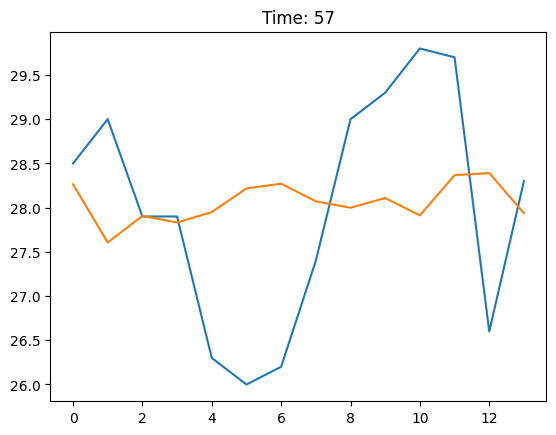

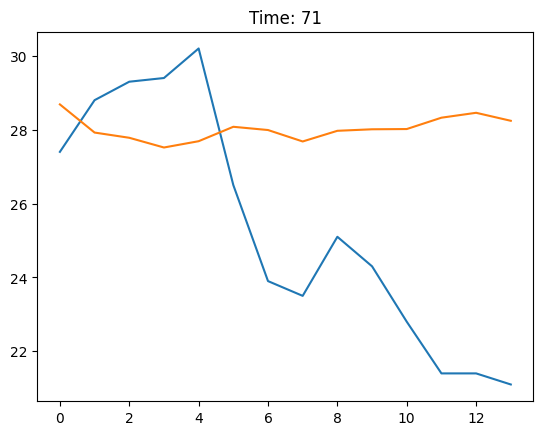

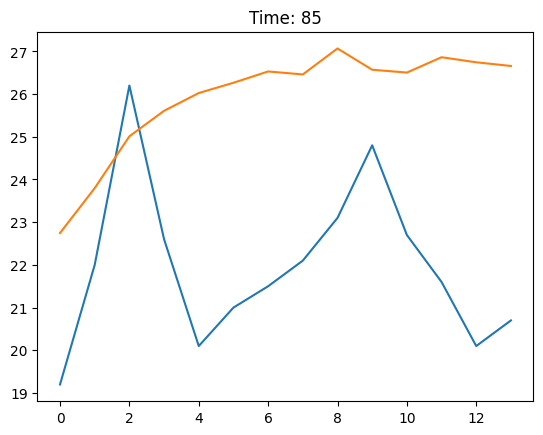

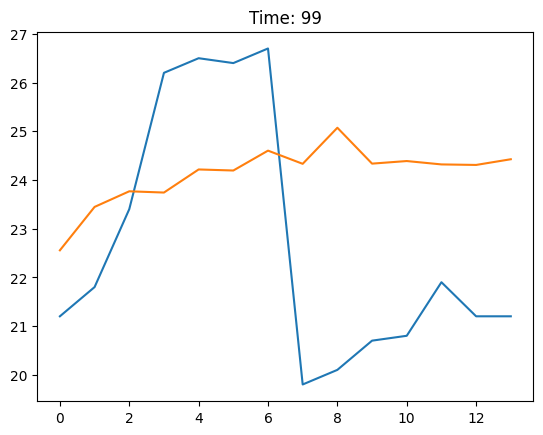

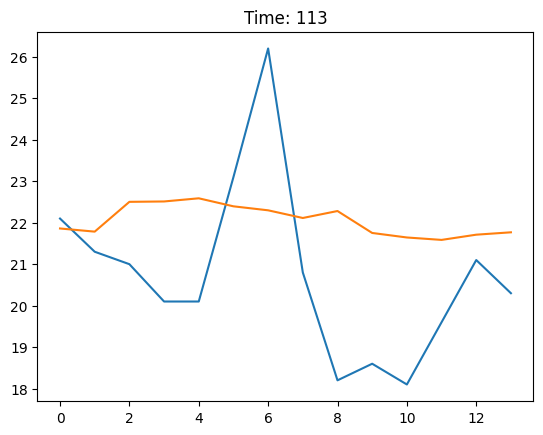

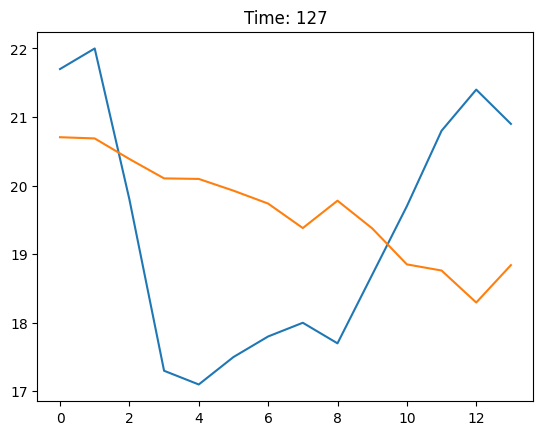

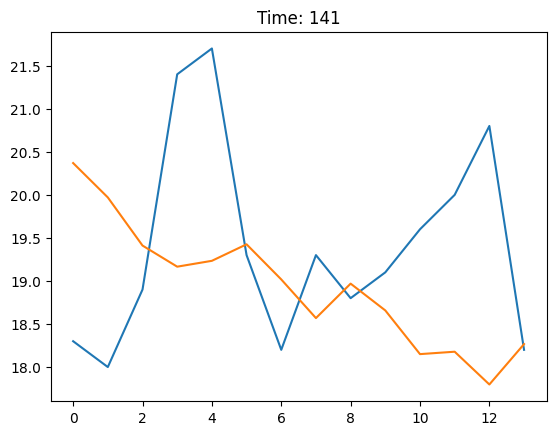

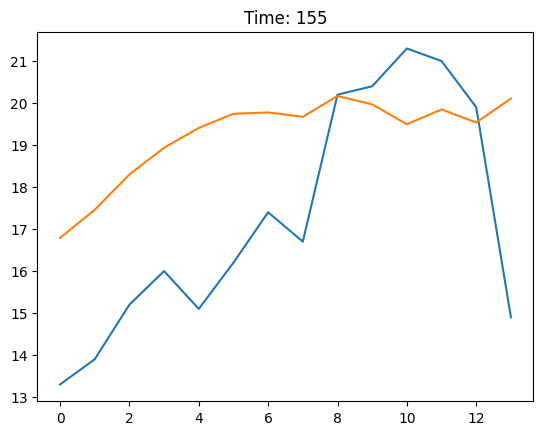

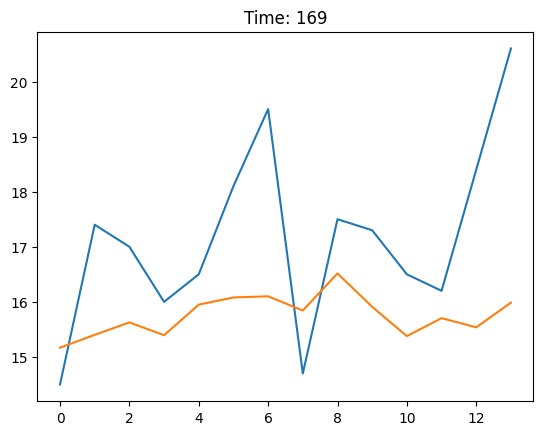

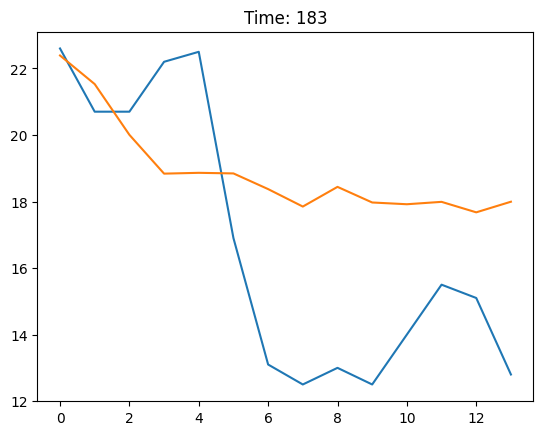

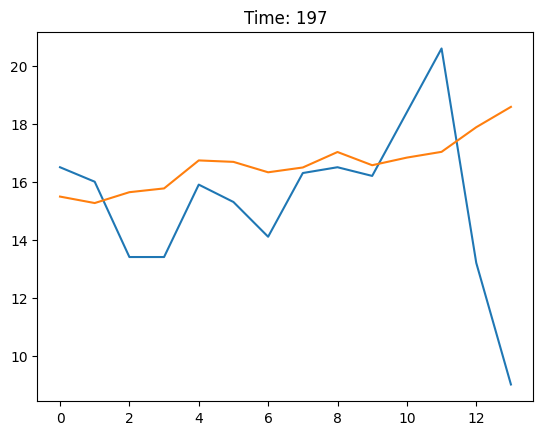

In [20]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
plt.legend(['Predict', 'True'])
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()